In [19]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import math
from datetime import datetime

In [27]:
train = pd.read_csv('train_final_best_2.csv')
test = pd.read_csv('test_final_best_2.csv')

## Length of the code {-}
No restriction

**Delete this section from the report, when using this template.** 

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Elton John*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [4]:
#...Distribution of continuous variables...#

In [5]:
#...Distribution of categorical variables...#

In [6]:
#...Association of the response with the predictors...#

### Data cleaning
*By Xena Valenzuela*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [7]:
#...Code with comments...#

### Data preparation
*By Sabrina Kozarovitsky*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Based on personal experience, I believe that certain hours and days may have more demand than others which may lead to higher prices. The data currently in date_hour is in a string format. In order to better use the day and time of the ride as a predictor in our model, it is important to convert date_hour into a datetime format. Additionaly, to see if hour and day may affect demand and in turn price, we can extract hour and day into separate columns to use as separate predictors. This code preparation will be useful in EDA.

In [28]:
type(train['date_hour'][0])

str

In [29]:
train['timestamp'] = train.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))
test['timestamp'] = test.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))

#Find hour of each trip
train['hour'] = train['timestamp'].dt.strftime('%H')
test['hour'] = test['timestamp'].dt.strftime('%H')

#Find date of each trip
train['date'] = train['timestamp'].dt.strftime('%Y-%m-%d') 
test['date'] = test['timestamp'].dt.strftime('%Y-%m-%d') 

#Find day name of each trip
train['day'] = train['timestamp'].dt.day_name()
test['day'] = test['timestamp'].dt.day_name()

# drop redundant fields 
train = train.drop('timestamp', axis=1)
test = test.drop('timestamp', axis=1)

In [30]:
#converting hour to int to ensure that EDA graphs are in order of time
train['hour']=train['hour'].astype('int')

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Cindy: General EDA

Text(28.209531249999998, 0.5, 'Price')

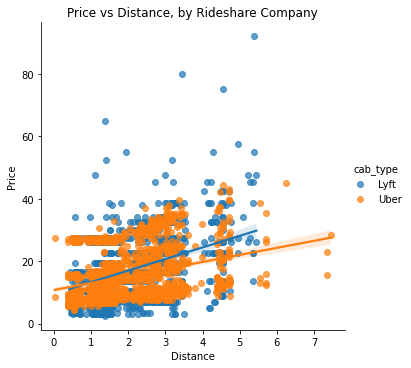

In [32]:
# seeing whether lyft vs uber is a good predictor of price
sns.lmplot(data = train, x = 'distance', y = 'price', hue = 'cab_type', scatter_kws={'alpha':0.7})
plt.title('Price vs Distance, by Rideshare Company')
plt.xlabel('Distance')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

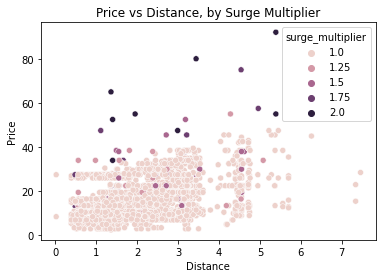

In [33]:
# investigating surge multiplier, although it was left out of further analysis since we don't know the surge multiplier value when predicting prices in real life
a = sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'surge_multiplier')
plt.title('Price vs Distance, by Surge Multiplier')
plt.xlabel('Distance')
plt.ylabel('Price')


### Cindy: Weather EDA

<AxesSubplot:xlabel='wind_d_strength', ylabel='price'>

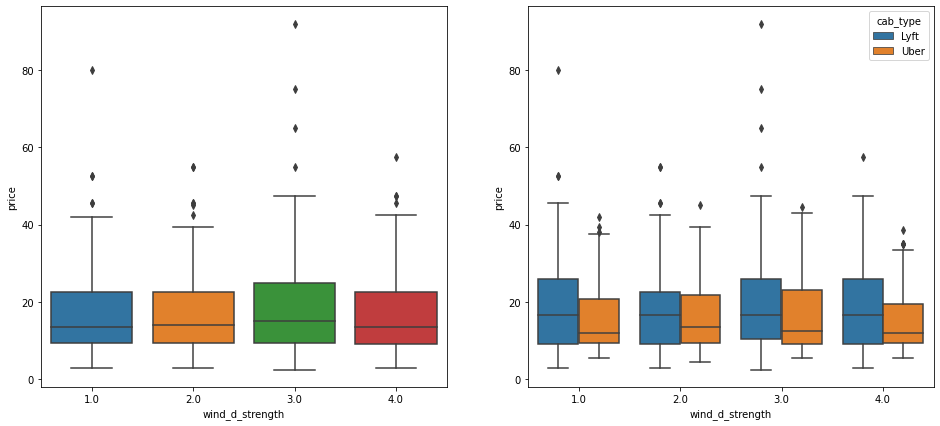

In [34]:
# wind 

# getting 25, 50, and 75th quartile amounts for wind
wd25, wd50, wd75 = train['wind'].quantile([0.25, 0.5, 0.75])
# creating separate column with values indicating how severe the wind was based on its relationship to the quartiles
train.loc[train['wind'] < wd25, 'wind_d_strength'] = 1
train.loc[((train['wind'] < wd50) & (train['wind'] >= wd25)), 'wind_d_strength'] = 2
train.loc[((train['wind'] < wd75) & (train['wind'] >= wd50)), 'wind_d_strength'] = 3
train.loc[train['wind'] >= wd75, 'wind_d_strength'] = 4
# graphing how wind strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax=ax[0], data = train, x = 'wind_d_strength', y = 'price')
sns.boxplot(ax=ax[1], data = train, x = 'wind_d_strength', y = 'price', hue = 'cab_type')

<AxesSubplot:xlabel='pressure_d_strength', ylabel='price'>

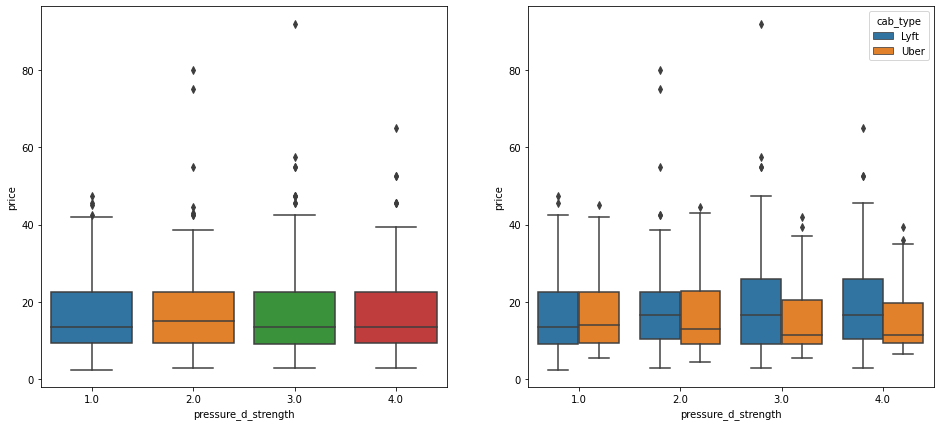

In [35]:
# pressure 

# getting 25, 50, and 75th quartile amounts for pressure
pd25, pd50, pd75 = train['pressure'].quantile([0.25, 0.5, 0.75])
# creating separate column with values indicating how severe the pressure was based on its relationship to the quartiles
train.loc[train['pressure'] < pd25, 'pressure_d_strength'] = 1
train.loc[((train['pressure'] < pd50) & (train['pressure'] >= pd25)), 'pressure_d_strength'] = 2
train.loc[((train['pressure'] < pd75) & (train['pressure'] >= pd50)), 'pressure_d_strength'] = 3
train.loc[train['pressure'] >= pd75, 'pressure_d_strength'] = 4
# graphing how pressure strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'pressure_d_strength', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'pressure_d_strength', y = 'price', hue = 'cab_type')


<AxesSubplot:xlabel='humidity_d_strength', ylabel='price'>

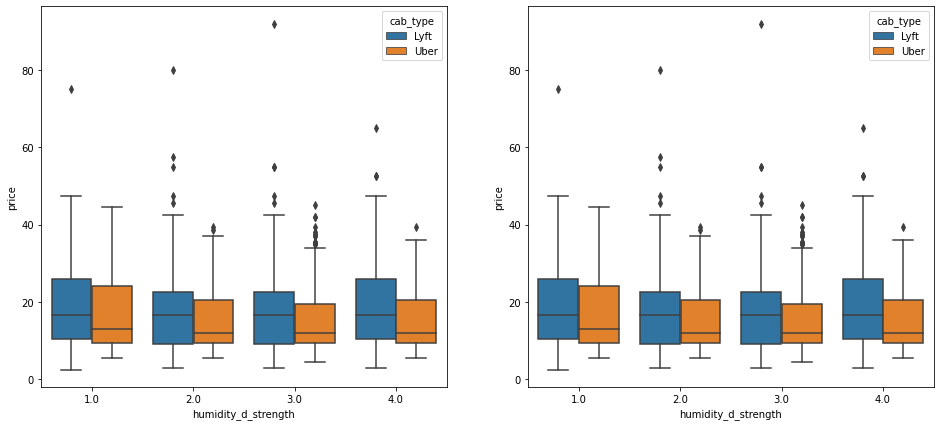

In [36]:
# humidity 

# getting 25, 50, and 75th quartile amounts for pressure
hd25, hd50, hd75 = train['humidity'].quantile([0.25, 0.5, 0.75])
#  # creating separate column with values indicating how severe the humidity was based on its relationship to the quartiles
train.loc[train['humidity'] < hd25, 'humidity_d_strength'] = 1
train.loc[((train['humidity'] < hd50) & (train['humidity'] >= hd25)), 'humidity_d_strength'] = 2
train.loc[((train['humidity'] < hd75) & (train['humidity'] >= hd50)), 'humidity_d_strength'] = 3
train.loc[train['humidity'] >= hd75, 'humidity_d_strength'] = 4
# graphing how humidity strength relates to price of ride, broken down by uber/lyft 
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')


<AxesSubplot:xlabel='humidity_strength_3', ylabel='price'>

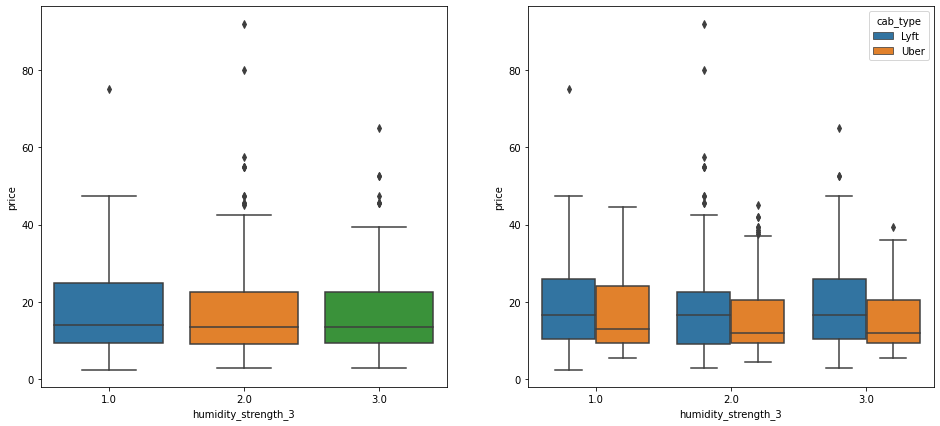

In [37]:
# trying to bin humidity into 3 instead of 4 to see if there's a stronger relationship...
train.loc[train['humidity'] < hd25, 'humidity_strength_3'] = 1
train.loc[((train['humidity'] < hd75) & (train['humidity'] >= hd25)), 'humidity_strength_3'] = 2
train.loc[train['humidity'] >= hd75, 'humidity_strength_3'] = 3
#plotting it again
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_strength_3', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_strength_3', y = 'price', hue = 'cab_type')
# there was no real difference 

In [38]:
# instead of using humidity, pressure, and wind on its own, create another indicator value for "bad" and "good" weather
# defined bad weather as rides where wind and rain strength were in the top 25th percentile (pressure was left out bc it's likely strongly related with rain)
train.loc[(train['wind_d_strength'] == 4) & (train['rain_d_strength'] == 4), 'bad_weather'] = 1
train.fillna(0, inplace = True)

#graph price based on whether it was good or bad weather
a = sns.boxplot(data = train, x = 'bad_weather', y = 'price')
plt.legend(bbox_to_anchor=(0.9, 0.93), borderaxespad=0)
a.set(title = 'Prices during Good and Bad Weather')
a.set(xlabel = 'Weather')
a.set(ylabel = 'Price')

KeyError: 'rain_d_strength'

In [39]:
# investigate how bad/good weather related with distance
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'bad_weather')
plt.title('Price vs Distance')
plt.xlabel('Distance')
plt.ylabel('Price')

ValueError: Could not interpret value `bad_weather` for parameter `hue`

### Cindy: Location EDA

In [40]:
# getting a dataframe containing the # of rides to/from each location
locationdf = pd.DataFrame(train['location'].value_counts()).reset_index()
locationdf.columns = ['location', 'count']
locationdf

,location,count
0,Haymarket Square,262
1,North Station,225
2,Northeastern University,221
3,South Station,208
4,Boston University,205
5,Theatre District,204
6,Beacon Hill,204
7,Financial District,202
8,Fenway,196
9,North End,188


[Text(0.5, 0, 'Location')]

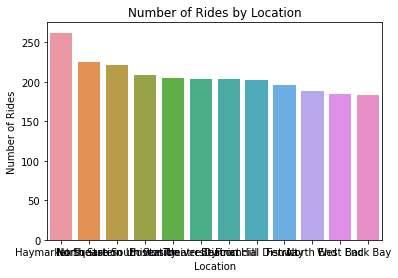

In [41]:
# it's roughly around the same area, but going to graph it to vizualize it better
a = sns.barplot(data = locationdf, x = 'location', y = 'count')
a.set(title='Number of Rides by Location')
a.set(ylabel='Number of Rides')
a.set(xlabel='Location')

In [42]:
locationprice = pd.DataFrame(train.groupby('location').agg('mean')['price']).reset_index()
locationprice

,location,price
0,Back Bay,17.467213
1,Beacon Hill,15.284314
2,Boston University,18.987805
3,Fenway,18.346939
4,Financial District,18.168317
5,Haymarket Square,14.024809
6,North End,15.781915
7,North Station,16.695556
8,Northeastern University,17.834842
9,South Station,16.192308


[Text(0.5, 0, 'Location')]

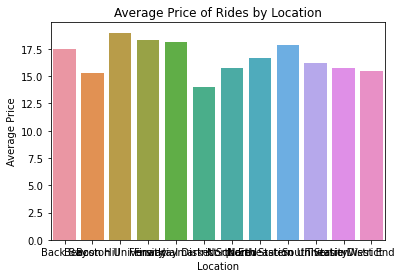

In [43]:
# vizualize avg price by location 
a = sns.barplot(data = locationprice, x = 'location', y = 'price')
a.set(title='Average Price of Rides by Location')
a.set(ylabel='Average Price')
a.set(xlabel='Location')

### Sabrina: Time EDA

<AxesSubplot:xlabel='hour', ylabel='price'>

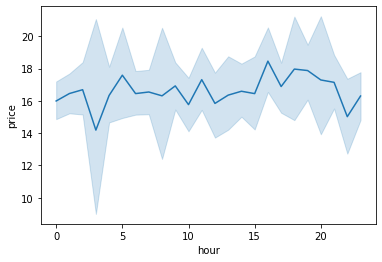

In [47]:
#Graphing to see average price by hour
sns.lineplot(x='hour', y='price', data=train)
#Average stays roughly between 14 and 18 dollars but is variable so we should consider different ways of binning hour

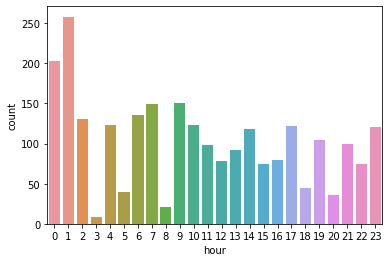

In [45]:
#Plotting counts of hour to see if some hours are more popular than others
a=sns.countplot(x='hour', data=train)
#Seems like the most rides occur between midnight and 2 am

In [48]:
#Creating function that will categorize hours with more than 175 rides as busiest, hours with approx. 100-175 rides as busy, and hours with less than 100 rides as not busy
def busy(x):
    if x['hour'] == 0 or x['hour']==1:
        return ('Busiest')
    if x['hour'] == 2 or x['hour']==4 or x['hour']==6 or x['hour']==7 or x['hour']==9 or x['hour']==10 or x['hour']==14 or x['hour']==17 or x['hour']==19 or x['hour']==22:
        return ('Busy')
    else:
        return ('Not Busy')

In [49]:
#applying function to dataframe
train['busyness'] = train.apply(lambda x: busy(x), axis=1)

<AxesSubplot:xlabel='busyness', ylabel='price'>

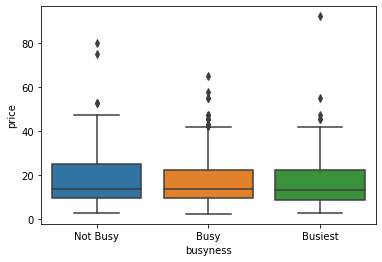

In [50]:
#Visualizing whether busier hours have higher prices
sns.boxplot(y='price', x='busyness', data=train)

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.